In [11]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [12]:
import os
import numpy as np
import time

from pprint import pprint
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from lenstronomy.Util import data_util
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman

from package.helpers import test_physical_lens
from package.plots import plot, diagnostic_plot

In [13]:
oversample_factor_list = [1, 3, 5, 7, 9]
execution_time = []

figure_dir = os.path.join(repo_path, 'figures', 'diagnostics', 'pixel_density_test')
array_dir = os.path.join(repo_path, 'output', 'arrays', 'diagnostics', 'pixel_density_test')

lens = test_physical_lens.TestPhysicalLens()

In [14]:
lenstronomy_roman_config = Roman(band='F106', psf_type='PIXEL', survey_mode='wide_area').kwargs_single_band()
magnitude_zero_point = lenstronomy_roman_config.get('magnitude_zero_point')

In [15]:
for oversample_factor in tqdm(oversample_factor_list):
    side = 5
    num_pix = 45 * oversample_factor

    image = lens.get_array(num_pix, side)

    plot.plot(filepath=os.path.join(figure_dir, f'model_{oversample_factor}.png'),
              title=f'Lenstronomy model\nOversampling factor {oversample_factor}', 
              array=image,
              colorbar=True)
    np.save(os.path.join(array_dir, f'model_{oversample_factor}'), image)

    # start timer
    start = time.time()

    calc = build_default_calc('roman', 'wfi', 'imaging')

    # scene size settings
    calc['configuration']['dynamic_scene'] = True
    calc['configuration']['max_scene_size'] = 5

    # change filter
    calc['configuration']['instrument']['filter'] = 'f106'

    # normalize (np.interp for now)
    j = 0
    side, _ = image.shape
    mag_array = np.zeros(image.shape)

    for row_number, row in tqdm(enumerate(image), total=side):
        for item_number, item in enumerate(row):
            mag_array[row_number][item_number] = data_util.cps2magnitude(item, magnitude_zero_point)
            j += 1

    i = 0
    print('Converting to point sources...')
    for row_number, row in tqdm(enumerate(mag_array)):
        for item_number, item in enumerate(row):
            if i != 0:
                calc['scene'].append(build_default_source(geometry="point"))

            # set brightness
            calc['scene'][i]['spectrum']['normalization']['norm_flux'] = item
            calc['scene'][i]['spectrum']['normalization']['norm_fluxunit'] = 'abmag'
            calc['scene'][i]['spectrum']['normalization']['norm_wave'] = 1.06
            calc['scene'][i]['spectrum']['normalization']['norm_waveunit'] = 'microns'
            calc['scene'][i]['spectrum']['normalization']['type'] = 'at_lambda'

            # set position
            calc['scene'][i]['position']['x_offset'] = (item_number * (1 / 9) * (
                        1 / oversample_factor)) + lens.ra_at_xy_0  # arcsec
            calc['scene'][i]['position']['y_offset'] = (row_number * (1 / 9) * (
                        1 / oversample_factor)) + lens.dec_at_xy_0  # arcsec

            i += 1
    print('Point source conversion complete')

    print('Performing Pandeia calculation...')
    results = perform_calculation(calc)
    print('Pandeia calculation complete')

    # stop timer
    stop = time.time()
    execution_time.append(stop - start)

    detector = results['2d']['detector']

    # TODO TEMP! flip image
    detector = np.flipud(detector)
    # detector = np.fliplr(detector)

    plot.plot(filepath=os.path.join(figure_dir, f'pandeia_{oversample_factor}.png'),
              title=f'Pandeia simulation\nOversampling factor {oversample_factor}', 
              array=detector,
              colorbar=True)

    # save this numpy array
    np.save(os.path.join(array_dir, f'detector_{oversample_factor}'), detector)

100%|██████████| 45/45 [00:00<00:00, 10539.04it/s]


Converting to point sources...


45it [00:10,  4.20it/s]


Point source conversion complete
Performing Pandeia calculation...


Pandeia calculation complete


100%|██████████| 135/135 [00:00<00:00, 4003.30it/s]


Converting to point sources...


135it [01:29,  1.51it/s]


Point source conversion complete
Performing Pandeia calculation...
Pandeia calculation complete


100%|██████████| 225/225 [00:00<00:00, 2645.38it/s]


Converting to point sources...


225it [04:11,  1.12s/it]


Point source conversion complete
Performing Pandeia calculation...


Pandeia calculation complete


100%|██████████| 315/315 [00:00<00:00, 1729.58it/s]


Converting to point sources...


315it [08:38,  1.65s/it]


Point source conversion complete
Performing Pandeia calculation...


Pandeia calculation complete


100%|██████████| 405/405 [00:00<00:00, 1448.81it/s]


Converting to point sources...


405it [13:41,  2.03s/it]


Point source conversion complete
Performing Pandeia calculation...


Pandeia calculation complete


100%|██████████| 5/5 [8:23:50<00:00, 6046.07s/it]  


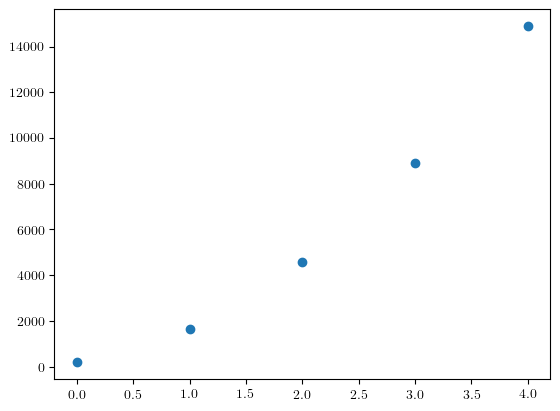

In [16]:
diagnostic_plot.execution_time_scatter(None, None, execution_time)

In [21]:
one = np.load(os.path.join(array_dir, 'detector_1.npy'))
three = np.load(os.path.join(array_dir, 'detector_3.npy'))
five = np.load(os.path.join(array_dir, 'detector_5.npy'))
seven = np.load(os.path.join(array_dir, 'detector_7.npy'))
nine = np.load(os.path.join(array_dir, 'detector_9.npy'))

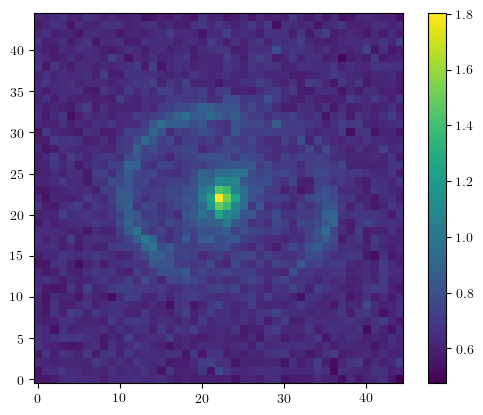

In [18]:
plot.plot(None, None, one, colorbar=True)

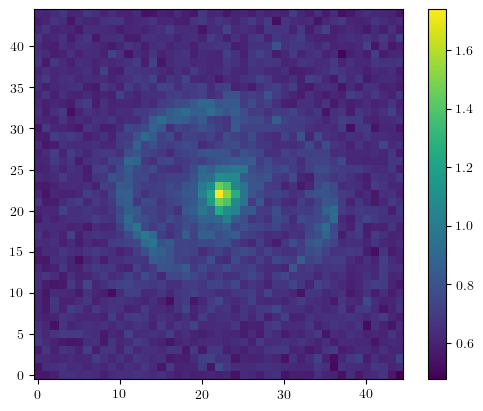

In [19]:
plot.plot(None, None, three, colorbar=True)

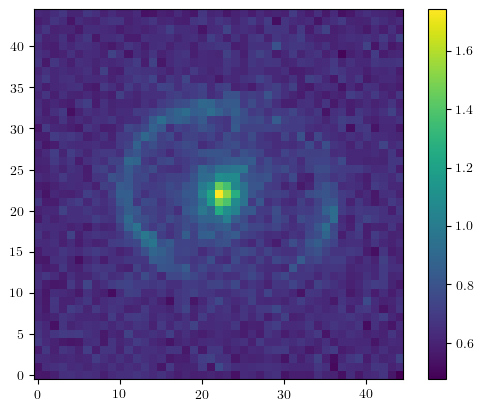

In [22]:
plot.plot(None, None, five, colorbar=True)

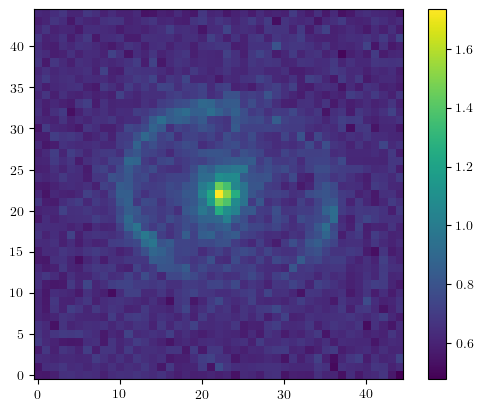

In [23]:
plot.plot(None, None, seven, colorbar=True)

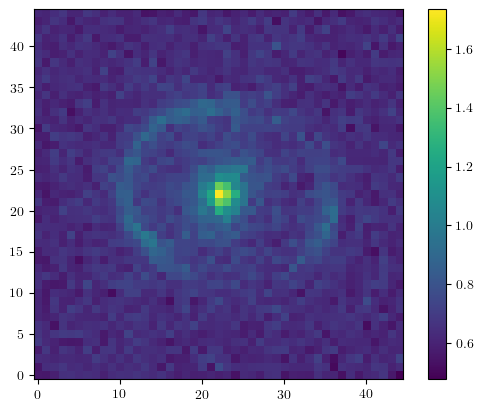

In [24]:
plot.plot(None, None, nine, colorbar=True)

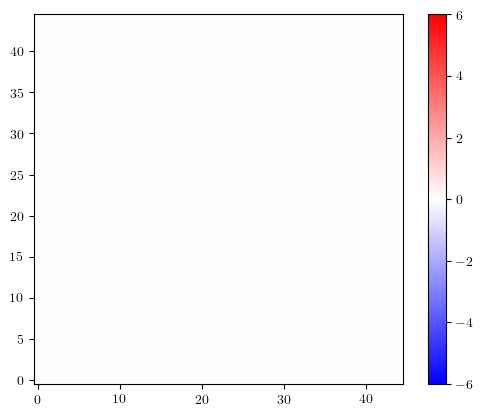

In [26]:
diagnostic_plot.residual(None, None, one, nine)